In [156]:
# Loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize as es
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [88]:
# Loading datasets
df_train, df_test = pd.read_csv("../doc/training.csv"), pd.read_csv("../doc/Test.csv")
df_train.head(1)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2


In [6]:
df_train.shape, df_test.shape

((84534, 10), (41650, 10))

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


A/B Test: Conversion Rate

Sample Size

In [8]:
target, exp_sub, treat, ctrl, alpha, beta = 'purchase', 'Promotion', 'Yes', 'No', 0.05, 0.2
n_treat, n_ctrl = getattr(df_train, exp_sub).value_counts().loc[treat], getattr(df_train, exp_sub).value_counts().loc[ctrl]
n_treat_pur, n_ctrl_pur = df_train.query(f"{exp_sub} == '{treat}'").loc[:, target].sum(), df_train.query(f"{exp_sub} == '{ctrl}'").loc[:, target].sum() 
pct_treat_pur, pct_ctrl_pur = (n_treat_pur / n_treat), (n_ctrl_pur / n_ctrl)
pct_benchmark, pct_improve = pct_ctrl_pur, 0.01
n_req_1 = 2 * np.mean([pct_benchmark, pct_benchmark+pct_improve]) * np.mean([1-pct_benchmark, 1-pct_benchmark-pct_improve]) * ((stats.norm.ppf(1-alpha/2) + stats.norm.ppf(1-beta))**2) / ((pct_improve)**2)
n_req_2 = zt_ind_solve_power(effect_size=es(prop1=0.0076, prop2=0.0176), alpha=0.05, power=0.8, alternative="two-sided")
print(f"# of Treatment: {str(n_treat)}, with purchase rate:{pct_treat_pur: .2%}; \n# of Control: {str(n_ctrl)}, with purchase rate:{pct_ctrl_pur: .2%}. \nIf require{pct_improve: .2%} improvement, need sample size {n_req_2:.0f}.")

# of Treatment: 42364, with purchase rate: 1.70%; 
# of Control: 42170, with purchase rate: 0.76%. 
If require 1.00% improvement, need sample size 1873.


Invariant Metric

1. Proportion of either group is 50% - Null Hypothesis: Treatment = 50%

In [9]:
p_0, n_obs = 0.5, df_train.shape[0]
p_hat = n_treat / n_obs
z_score = (p_hat - p_0) / np.sqrt(p_hat*(1-p_hat)/n_obs)
p_value = 2*stats.norm.cdf(-z_score)
print(f'Z score of equal proportion is{z_score: .2f}, p-value is{p_value: .3f}')

Z score of equal proportion is 0.67, p-value is 0.505


2. Features' distribution same

In [10]:
def features_ks(df=None, exp_sub='Promotion', treat= 'Yes', ctrl='No', cols=None):
    for col in cols:
        n1, n2 = df.query(f"{exp_sub} == '{treat}'").loc[:, col], df.query(f"{exp_sub} == '{ctrl}'").loc[:, col]
        print(f"{col}: {stats.ks_2samp(n1, n2)}")
    return

features = ['V' + str(i) for i in range(1, 8)]
features_ks(df=df_train, cols=features)

V1: KstestResult(statistic=0.0048022292743130635, pvalue=0.7124802208185219, statistic_location=1, statistic_sign=-1)
V2: KstestResult(statistic=0.0036685883717404444, pvalue=0.9375669484920104, statistic_location=26.46787, statistic_sign=1)
V3: KstestResult(statistic=0.009532371938205442, pvalue=0.04268951361445461, statistic_location=0.13358341, statistic_sign=-1)
V4: KstestResult(statistic=0.0013212266279392648, pvalue=0.9999999999999426, statistic_location=1, statistic_sign=1)
V5: KstestResult(statistic=0.0030495498804616883, pvalue=0.9890605670600565, statistic_location=3, statistic_sign=1)
V6: KstestResult(statistic=0.0010121893329728682, pvalue=1.0, statistic_location=2, statistic_sign=-1)
V7: KstestResult(statistic=0.001020390890767331, pvalue=1.0, statistic_location=1, statistic_sign=1)


Evaluation Metric - Conversion Rate

In [11]:
z_score = (pct_treat_pur - pct_ctrl_pur) / np.sqrt((getattr(df_train, target).sum()/df_train.shape[0]) * (1-(getattr(df_train, target).sum()/df_train.shape[0])) * (1/n_treat + 1/n_ctrl))
p_value = stats.norm.cdf(-z_score)
print(f'Z score is{z_score: .2f}, p-value is{p_value: .2f}')

Z score is 12.47, p-value is 0.00


Analysis of IRR & NIR, with BootStrapping under Null Hypothesis: IRR <= 0 & NIR <= 0

In [12]:
irr = pct_treat_pur - pct_ctrl_pur
nir = (10 * n_treat_pur - 0.15 * n_treat) - 10 * n_ctrl_pur
print(f'IRR is{irr: .2%}, NIR is {nir: .2f}')

IRR is 0.95%, NIR is -2334.60


In [13]:
n_trails, nirs, irrs = 2000, [], []

def get_irr_nir(df=None, exp_sub='Promotion', treat= 'Yes', ctrl='No', target='purchase'):
    n_treat, n_ctrl = df.query(f"{exp_sub} == '{treat}'").shape[0], df.query(f"{exp_sub} == '{ctrl}'").shape[0]
    n_treat_pur, n_ctrl_pur = df.query(f"{exp_sub} == '{treat}'").loc[:, target].sum(), df.query(f"{exp_sub} == '{ctrl}'").loc[:, target].sum()
    irr = n_treat_pur / n_treat - n_ctrl_pur / n_ctrl
    nir = (10 * n_treat_pur - 0.15 * n_treat) - 10 * n_ctrl_pur
    return irr, nir

for _ in range(n_trails):
    sub_sample = df_train.sample(frac=1., replace=True)
    irr, nir = get_irr_nir(sub_sample)
    nirs.append(nir)
    irrs.append(irr)

In [14]:
'''IRR'''
h_0, n_obs, se = 0, n_trails, np.std(irrs)
irr_mean = np.mean(irrs)
z_score = (irr_mean - h_0) / (se/np.sqrt(n_obs))
p_value = stats.norm.cdf(-z_score)
print(f'Z score of Invariant Metric is{z_score: .2f}, p-value is{p_value: .2f}')

Z score of Invariant Metric is 552.23, p-value is 0.00


In [15]:
'''NIR'''
h_0, n_obs, se = 0, n_trails, np.std(nirs)
nir_mean = np.mean(nirs)
z_score = (nir_mean - h_0) / (se/np.sqrt(n_obs))
p_value = stats.norm.cdf(-z_score)
print(f'Z score of Invariant Metric is{z_score: .2f}, p-value is{p_value: .2f}')

Z score of Invariant Metric is-325.44, p-value is 1.00


Exploratory Data Analysis (EDA)

In [16]:
df_train.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [17]:
def vars_corr(data=None, category=None, features_corr=None, subplots=[1,3], figsize=(20,6)):
    sns.set()
    fig, axes = plt.subplots(nrows = subplots[0], ncols = subplots[1], figsize = figsize)
    ax, i = axes.flatten(), 0
    for cat in category:
        if cat in ('Yes', 'No'):
            df_sub = data.query(f"Promotion == '{cat}'")
            df_corr = df_sub[features_corr].corr()
            temp = sns.heatmap(df_corr, annot=True, vmin = -.3, vmax = .3, center = 0, cmap = 'RdYlBu', square = True, ax=ax[i])
            temp.set_title(f'Correlation Matrix - Purchase {cat}')
        if cat == 'All':
            df_sub = data.copy()
            df_corr = df_sub[features_corr].corr()
            temp = sns.heatmap(df_corr, annot=True, vmin = -.3, vmax = .3, center = 0, cmap = 'RdYlBu', square = True, ax=ax[i])
            temp.set_title(f'Correlation Matrix - Purchase {cat}')
        i += 1
    fig.tight_layout()
    return

def vars_dist(data=None, category=None, cols=None, continuous_x=None, subplots=[3,7], figsize=(30,15)):
    sns.set()
    fig, axes = plt.subplots(nrows = subplots[0], ncols = subplots[1], figsize = figsize)
    ax, i = axes.flatten(), 0
    for cat in category:
        if cat != 'All':
            df = data.query(f"Promotion == '{cat}'")
        else:
            df = data.copy()
        for col in cols:
            if col in continuous_x:
                temp = sns.histplot(getattr(df, col), kde=True, color='purple', ax=ax[i])
                temp.set(xlabel=col, ylabel='Density', title=f"Histogram of {col} - {cat}")
            else: 
                temp = sns.countplot(data=df, x=col, ax=ax[i])
                temp.set(xlabel=col, ylabel='Count', title=f"Countplot of {col} - {cat}")
            i += 1
    fig.tight_layout()
    return

features, target = ['V' + str(i) for i in range(1, 8)], 'purchase'
features.append(target)

Correlation

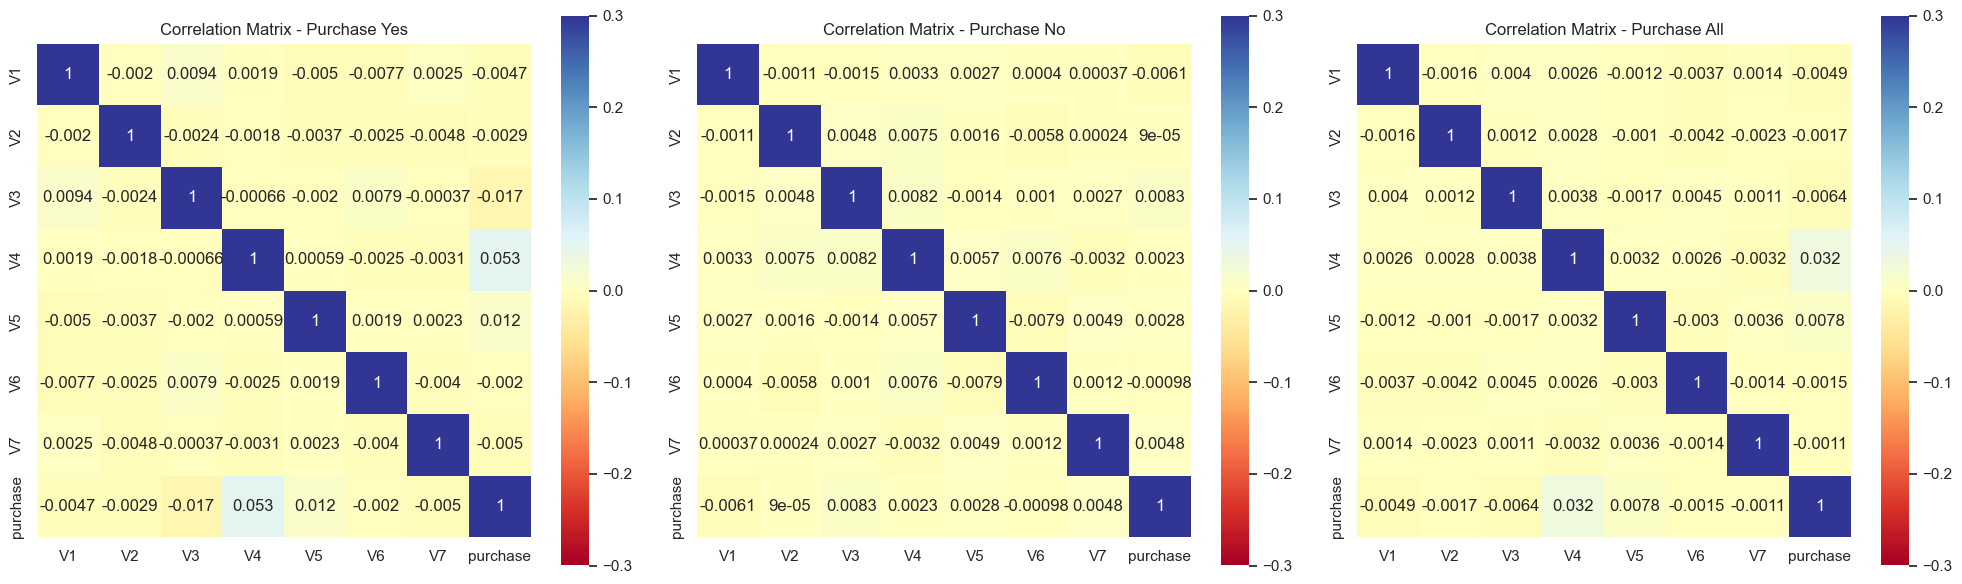

In [18]:
vars_corr(data=df_train, category=['Yes', 'No', 'All'], features_corr=features)

In [19]:
purch_corr_df = pd.DataFrame()
purch_corr_df['control'] = df_train.query("Promotion == 'No'").loc[:, features].corr()['purchase']
purch_corr_df['treat'] = df_train.query("Promotion == 'Yes'").loc[:, features].corr()['purchase']
purch_corr_df['delta_pct'] = -((purch_corr_df.control - purch_corr_df.treat)/purch_corr_df.control)*100
purch_corr_df

,control,treat,delta_pct
V1,-0.006088,-0.004651,-23.605724
V2,0.000090,-0.002885,-3306.003045
V3,0.008325,-0.017012,-304.357526
V4,0.002344,0.053348,2176.227435
V5,0.002771,0.011711,322.600958
V6,-0.000980,-0.002049,109.222660
V7,0.004786,-0.005005,-204.587034
purchase,1.000000,1.000000,-0.000000


Distribution

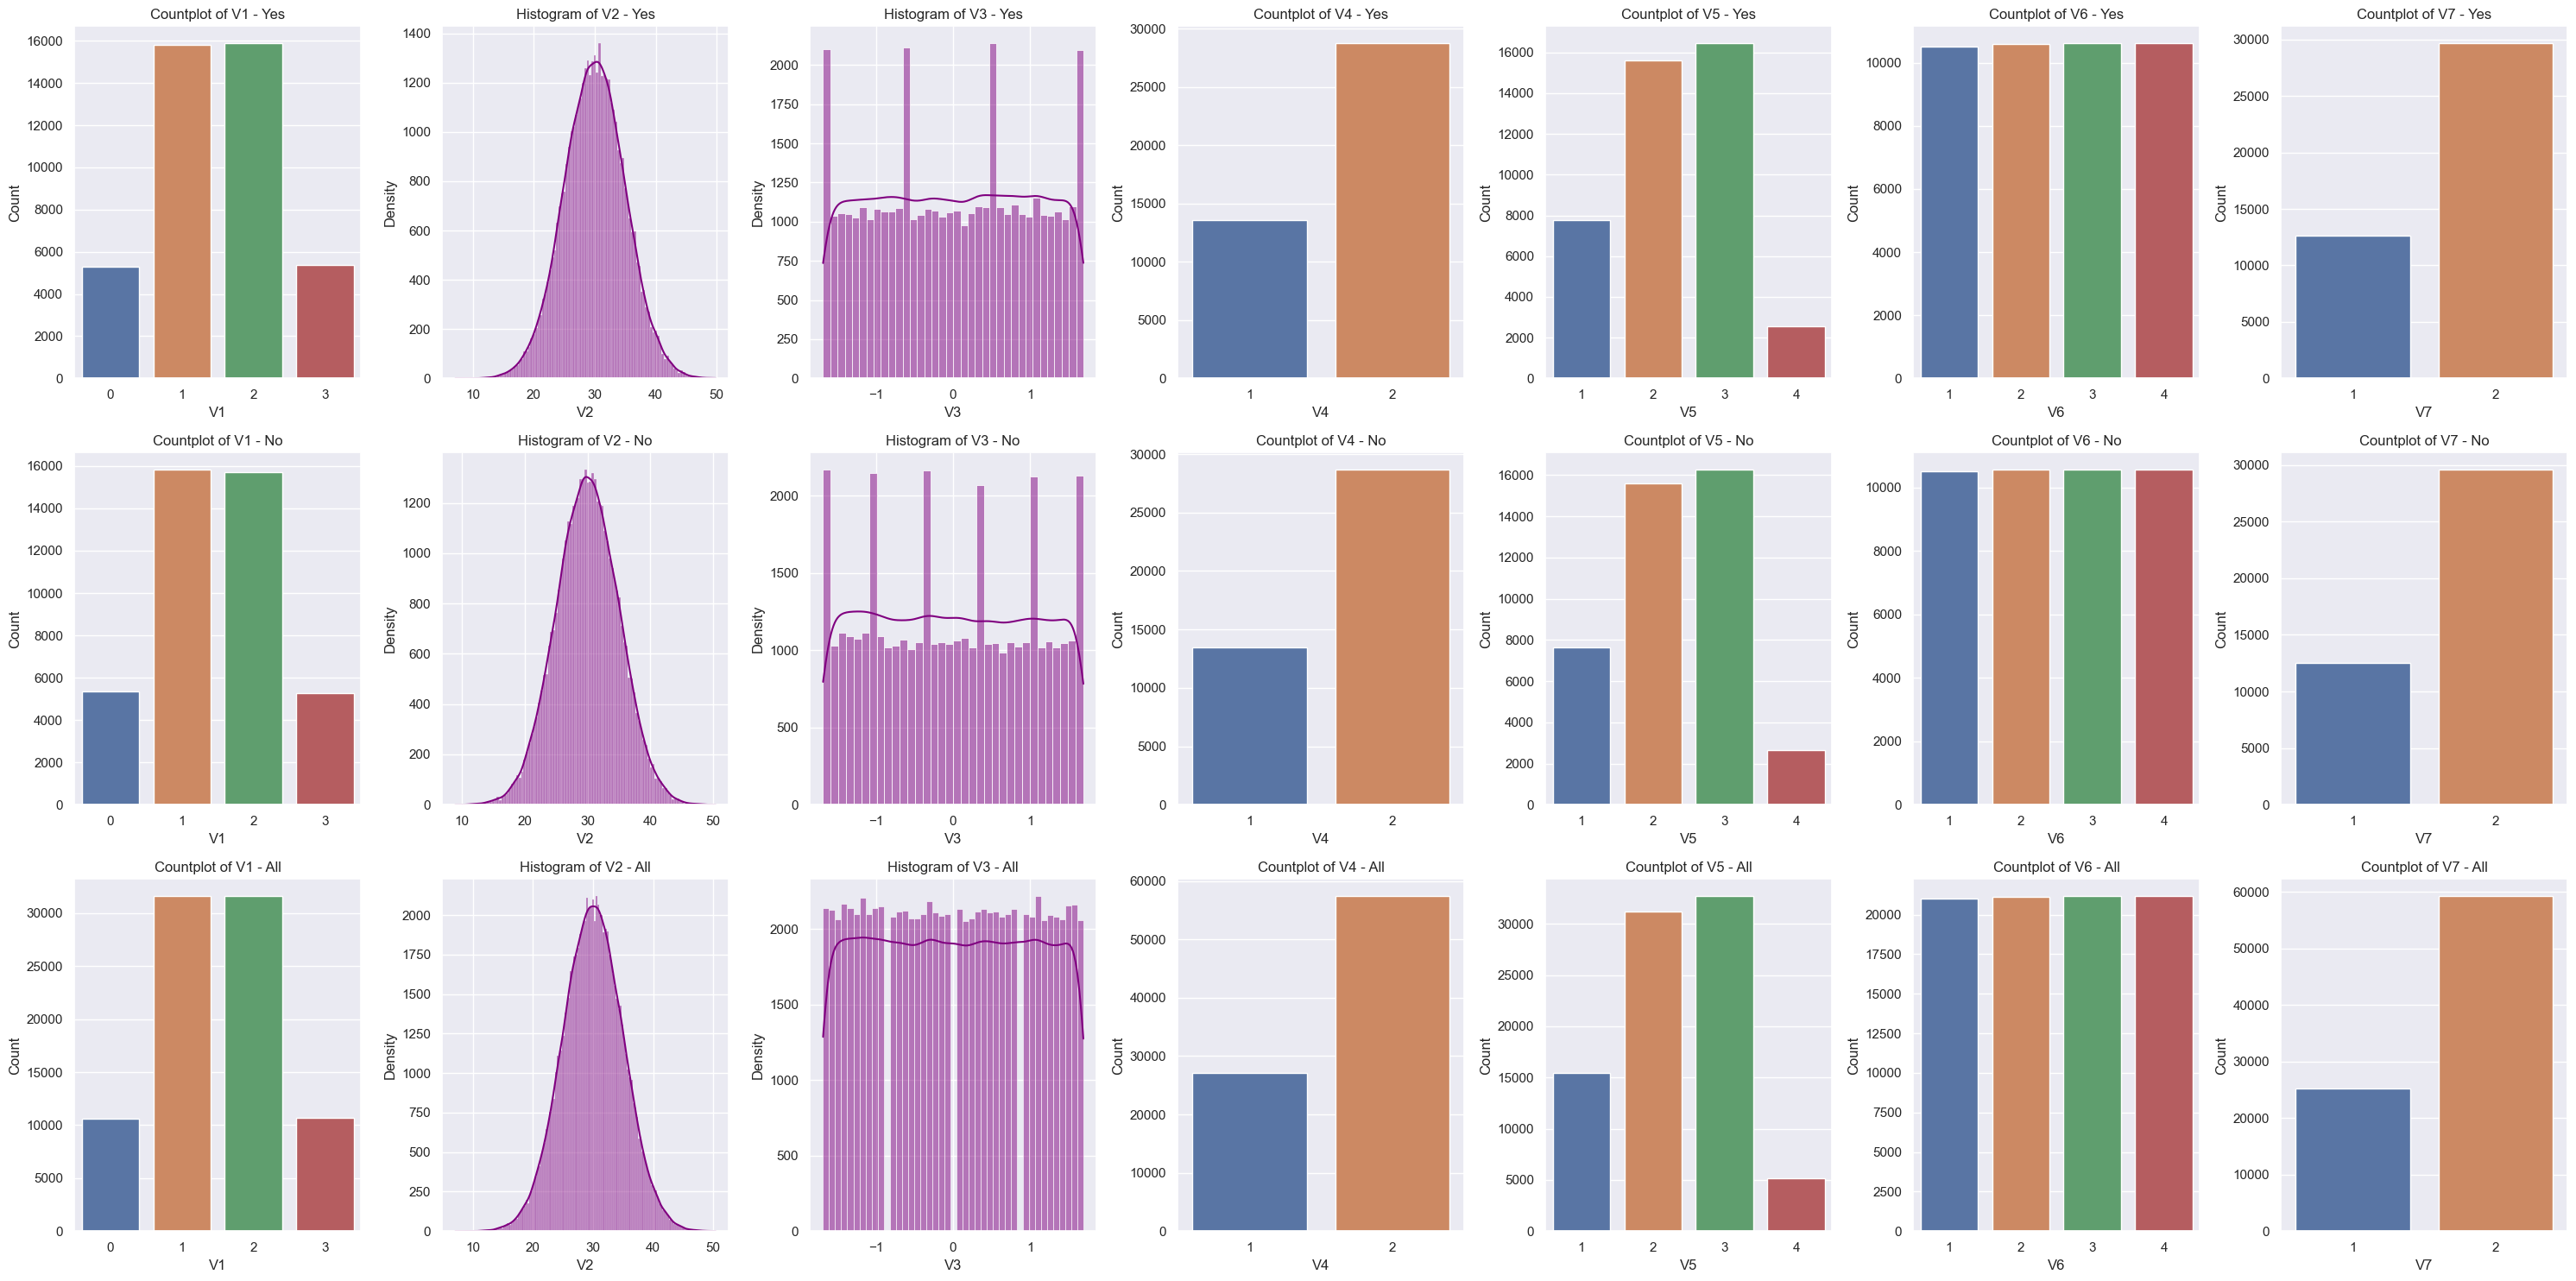

In [20]:
features.remove(target)
vars_dist(data=df_train, category=['Yes', 'No', 'All'], cols=features, continuous_x=['V2', 'V3'])

Feature Engineering

In [21]:
features.append(exp_sub)
features

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'Promotion']

In [22]:
X_train, y_train, X_test, y_test = df_train[features], df_train[target], df_test[features], df_test[target]
getattr(X_train, exp_sub).replace({'Yes': 1, 'No': 0}, inplace=True)
X_test.drop(columns=[exp_sub], inplace=True)
X_test[f"{exp_sub}_1"], X_test[f"{exp_sub}_0"] = 1, 0

In [65]:
X_test_1 = X_test.drop(columns=[f"{exp_sub}_0"]).rename(columns={f"{exp_sub}_1" :exp_sub})
X_test_0 = X_test.drop(columns=[f"{exp_sub}_1"]).rename(columns={f"{exp_sub}_0" :exp_sub})
X_test_orig = X_test.drop(columns=[f"{exp_sub}_1", f"{exp_sub}_0"])
X_train_orig = X_train.drop(columns=[f"{exp_sub}"])

Imbalanced - SMOTE

In [23]:
weight_0 = y_train.value_counts().loc[0]/y_train.value_counts().sum()
weight_1 = 1-weight_0
print(f"Class 0 has # of {y_train.value_counts().loc[0]}, with weight of {weight_0: .2%}; \nClass 1 has # of {y_train.value_counts().loc[1]}, with weight of {weight_1: .2%}")

Class 0 has # of 83494, with weight of  98.77%; 
Class 1 has # of 1040, with weight of  1.23%


Modeling

Evaluation Metrics

In [123]:
def test_results(promotion_strategy, model, strategy=1):
    df_test = pd.read_csv("../doc/Test.csv")
    if strategy == 1:
        df = df_test[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    elif strategy == 2:
        df = df_test[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'Promotion']]
    if model is not None:
        df_test['Promotion'] = promotion_strategy(df, model, strategy)
    irr, nir = get_irr_nir(df_test)
    print(f'IRR is{irr: .2%}, NIR is {nir: .2f}')
    return

def promotion_strategy(df, model, strategy):
    if strategy == 2:
        df_0, df_1 = df.copy(), df.copy()
        df_0['Promotion'], df_1['Promotion'] = 0, 1
        y_pred_prob_0, y_pred_prob_1 = model.predict_proba(df_0)[:,1], model.predict_proba(df_1)[:,1]
        y_pred = []
        for i in range(len(y_pred_prob_0)):
            if y_pred_prob_0[i] >= 0.5:
                y_pred.append(0)
            elif y_pred_prob_1[i] >= 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        y_pred = np.array(y_pred)
        y_pred = np.where(y_pred==1, 'Yes', 'No')
    elif strategy == 1:
        y_pred = model.predict(df)
        y_pred = np.where(y_pred==1, 'Yes', 'No')
    print(model.__class__.__name__)
    return y_pred

def get_irr_nir(df=None, exp_sub='Promotion', treat= 'Yes', ctrl='No', target='purchase'):
    n_treat, n_ctrl = df.query(f"{exp_sub} == '{treat}'").shape[0], df.query(f"{exp_sub} == '{ctrl}'").shape[0]
    n_treat_pur, n_ctrl_pur = df.query(f"{exp_sub} == '{treat}'").loc[:, target].sum(), df.query(f"{exp_sub} == '{ctrl}'").loc[:, target].sum()
    irr = n_treat_pur / n_treat - n_ctrl_pur / n_ctrl
    nir = (10 * n_treat_pur - 0.15 * n_treat) - 10 * n_ctrl_pur
    return irr, nir

In [92]:
test_results(promotion_strategy, model=None)

IRR is 0.96%, NIR is -1132.20


Baseline - Logistic Regression

In [95]:
lr_clf = LogisticRegression(class_weight = 'balanced').fit(X_train_orig, np.ravel(y_train))
test_results(promotion_strategy, model=lr_clf, strategy=1)

LogisticRegression
IRR is 0.78%, NIR is -1151.05


In [124]:
lr_clf = LogisticRegression(class_weight = 'balanced').fit(X_train, np.ravel(y_train))
test_results(promotion_strategy, model=lr_clf, strategy=2)

LogisticRegression
IRR is 0.84%, NIR is -990.00


SMOTE

In [132]:
sm=SMOTE(random_state=42)
X_train_up, y_train_up = sm.fit_resample(X_train, y_train)
X_train_orig_up, y_train_orig_up = sm.fit_resample(X_train_orig, y_train)
X_train_up.shape, X_train_orig_up.shape, y_train_up.value_counts(), y_train_orig_up.value_counts()

((166988, 8),
 (166988, 7),
 0    83494
 1    83494
 Name: purchase, dtype: int64,
 0    83494
 1    83494
 Name: purchase, dtype: int64)

In [138]:
lr_clf = LogisticRegression(class_weight = 'balanced').fit(X_train_orig_up, np.ravel(y_train_orig_up))
test_results(promotion_strategy, model=lr_clf, strategy=1)

LogisticRegression
IRR is 0.48%, NIR is -2334.00


In [136]:
lr_clf = LogisticRegression(class_weight = 'balanced').fit(X_train_up, np.ravel(y_train_up))
test_results(promotion_strategy, model=lr_clf, strategy=2)

LogisticRegression
IRR is 0.16%, NIR is -3056.35


Ensemble - Random Forest, GridSearchCV

X_train / X_train_orig -> y_train

X_train_orig_up  -> y_train_orig_up

X_train_up  -> y_train_up

In [148]:
rf_clf = BalancedRandomForestClassifier(max_depth=5, random_state=42,n_estimators=1000).fit(X_train_orig, np.ravel(y_train))
test_results(promotion_strategy, model=rf_clf, strategy=1)

BalancedRandomForestClassifier
IRR is 1.04%, NIR is -986.25


In [164]:
param_grid = {'max_depth':[3, 5, 10],
              'min_samples_split':[2, 3],
              'min_samples_leaf':[1, 2],
              'max_features':[2, 3, 4, 5, 7],
              'max_samples':[0.9, 1.0]
             }
metrics = ['accuracy','f1','precision','recall']
brf_clf = GridSearchCV(estimator=BalancedRandomForestClassifier(random_state=42, n_estimators=200, bootstrap=True, class_weight='balanced_subsample',n_jobs=-1),
                       param_grid=param_grid,
                       cv=10,
                       scoring=metrics,
                       refit='recall',
                       error_score='raise'
                       ,verbose=2
                       )

brf_clf.fit(X_train_orig, np.ravel(y_train))
brf_clf.best_params_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   4.6s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_depth=3, max_features=2, max_samples=0.9, min_samples_leaf=1, min_samples_split=2; total time=   0.5s
[CV] END max_de

{'max_depth': 3,
 'max_features': 3,
 'max_samples': 0.9,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [165]:
test_results(promotion_strategy, model=brf_clf, strategy=1)

GridSearchCV
IRR is 0.99%, NIR is -863.00


In [149]:
rf_clf = BalancedRandomForestClassifier(max_depth=5, random_state=42,n_estimators=1000).fit(X_train, np.ravel(y_train))
test_results(promotion_strategy, model=rf_clf, strategy=2)

BalancedRandomForestClassifier
IRR is 0.85%, NIR is -999.20


In [142]:
rf_clf = RandomForestClassifier(max_depth=5, random_state=42,n_estimators=1000).fit(X_train_orig_up, np.ravel(y_train_orig_up))
test_results(promotion_strategy, model=rf_clf, strategy=1)

RandomForestClassifier
IRR is 0.50%, NIR is -2250.85


In [143]:
rf_clf = RandomForestClassifier(max_depth=5, random_state=42,n_estimators=1000).fit(X_train_up, np.ravel(y_train_up))
test_results(promotion_strategy, model=rf_clf, strategy=2)

RandomForestClassifier
IRR is 0.42%, NIR is -2261.55


XGBoost

In [159]:
xgb_clf = XGBClassifier(objective = 'binary:logistic', seed = 301, verbosity = 0).fit(X_train_orig, np.ravel(y_train))
test_results(promotion_strategy, model=xgb_clf, strategy=1)

XGBClassifier
IRR is-1.15%, NIR is -4800.15


In [160]:
xgb_clf = XGBClassifier(objective = 'binary:logistic', seed = 301, verbosity = 0).fit(X_train, np.ravel(y_train))
test_results(promotion_strategy, model=xgb_clf, strategy=2)

XGBClassifier
IRR is-1.15%, NIR is -4800.30


In [161]:
xgb_clf = XGBClassifier(objective = 'binary:logistic', seed = 301, verbosity = 0).fit(X_train_orig_up, np.ravel(y_train_orig_up))
test_results(promotion_strategy, model=xgb_clf, strategy=1)

XGBClassifier
IRR is 0.87%, NIR is -4612.05


In [163]:
xgb_clf = XGBClassifier(objective = 'binary:logistic', seed = 301, verbosity = 0).fit(X_train_up, np.ravel(y_train_up))
test_results(promotion_strategy, model=xgb_clf, strategy=2)

XGBClassifier
IRR is 0.64%, NIR is -4431.95
